In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Bernoulli, Normal

In [2]:
class FLAGS:
    N=50
    M=60
    D=3

In [3]:
def build_toy_dataset(U, V, N, M, noise_std=0.1):
  R = np.dot(np.transpose(U), V) + np.random.normal(0, noise_std, size=(N, M))
  return (R > 0).astype(int)


def get_indicators(N, M, prob_std=0.5):
  ind = np.random.binomial(1, prob_std, (N, M))
  return ind


In [4]:
# true latent factors
U_true = np.random.randn(FLAGS.D, FLAGS.N)
V_true = np.random.randn(FLAGS.D, FLAGS.M)
# add some structure to latent factors
U_true[:,:FLAGS.N//2] += 0.5
U_true[:,FLAGS.N//2:] -= 0.5
V_true[:,:FLAGS.M//2] += 0.5
V_true[:,FLAGS.M//2:] -= 0.5

# DATA
R_true = build_toy_dataset(U_true, V_true, FLAGS.N, FLAGS.M)
I_train = get_indicators(FLAGS.N, FLAGS.M)
I_test = 1 - I_train

# MODEL
I = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.M])
U = Normal(loc=0.0, scale=1.0, sample_shape=[FLAGS.D, FLAGS.N])
V = Normal(loc=0.0, scale=1.0, sample_shape=[FLAGS.D, FLAGS.M])
# R = Normal(loc=tf.matmul(tf.transpose(U), V) * I,
#            scale=tf.ones([FLAGS.N, FLAGS.M]))
R = Bernoulli(logits=tf.matmul(tf.transpose(U), V) * I)

# INFERENCE
qU = Normal(loc=tf.get_variable("qU/loc", [FLAGS.D, FLAGS.N]),
          scale=tf.nn.softplus(
              tf.get_variable("qU/scale", [FLAGS.D, FLAGS.N])))
qV = Normal(loc=tf.get_variable("qV/loc", [FLAGS.D, FLAGS.M]),
          scale=tf.nn.softplus(
              tf.get_variable("qV/scale", [FLAGS.D, FLAGS.M])))

inference = ed.KLqp({U: qU, V: qV}, data={R: R_true, I: I_train})
inference.run()

# CRITICISM
qR = Normal(loc=tf.matmul(tf.transpose(qU), qV),
          scale=tf.ones([FLAGS.N, FLAGS.M]))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={qR: R_true, I: I_test}))

/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 1795.186
Mean squared error on test data:
5.9081545


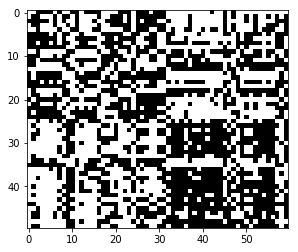

In [5]:
plt.imshow(R_true, cmap='binary')
plt.show()

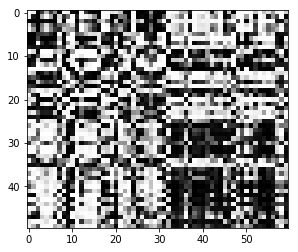

In [6]:
# R_est = tf.matmul(tf.transpose(qU), qV).eval()
# R_est = Bernoulli(logits=tf.matmul(tf.transpose(qU), qV)).eval()
# evaluate at posterior mean
R_est = Bernoulli(logits=tf.matmul(tf.transpose(qU), qV)).mean().eval()
plt.imshow(R_est, cmap='binary')
plt.show()

In [7]:
# Can I get Fisher information of posterior density?